In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor


In [157]:
# Функция для оценки модели через построение графиков
def check_model(model=None, name="Model", day=1):
    # iloc конвертирует в список, потому что нельзя передать DF
    prediction = model.predict([X_test.iloc[day-1]])[0]
    real = Y_test.iloc[day-1]  
    mae = mean_absolute_error(prediction, real)
    # Построение двух графиков в одном окне
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    fig.suptitle(f"День {day}, {name}, mae = {mae}", fontsize=18)
    # График предсказаний
    axs[0].plot(prediction)
    axs[0].plot(real)
    axs[0].set_title('Предсказание курса доллара США')
    axs[0].set_xlabel('день')
    axs[0].set_ylabel('курс доллара США')
    # График ошибки
    error = abs(prediction-real) # Абсолютная ошибка для каждого дня
    axs[1].plot(error)
    axs[1].set_title('Абсолютная ошибка')
    axs[1].set_xlabel('день')
    plt.show()
    return mae # возвращаем ошибку для оценки

# Функция для оценки - какое количество предсказаний из 10 соответствует точности 0.8?
def check_model_days(model=None, error=0.8):
    count = 0
    for i in range(10):
        prediction = model.predict([X_test.iloc[i]])[0]
        real = Y_test.iloc[i]  
        mae = mean_absolute_error(prediction, real)
        if mae <= error:
            count = count + 1
    return count

In [236]:
# Подготовка данных для их загрузки в модель
# Курс доллара за 01.01.2018 - 01.07.2020
usd_rates = pd.read_excel("usd_rates.xlsx")

future = 7  # Предсказание на "future" дней
past = 4 * 7  # Предсказание на основе "past" дней
money = usd_rates.curs
start = past  # День, когда мы начинаем собирать данные для обучения
end = money.size - future  # День, когда заканчиваем

training_past = []
training_future = []
for day in range(start, end):
    past_data = money[(day-past):day]
    future_data = money[day:(day+future)]
    training_past.append(list(past_data))
    training_future.append(list(future_data))

# Генерация имён для столбцов DataFrame
future_columns = []
for i in range(future):
    future_columns.append(f"future_{i}")
past_columns = []
for i in range(past):
    past_columns.append(f"past_{i}")

past_df = pd.DataFrame(training_past, columns=past_columns)
future_df = pd.DataFrame(training_future, columns=future_columns)  

# Учебник - training set
X_train = past_df[:-10]
Y_train = future_df[:-10]
# Экзамен - test set
X_test = past_df[-10:]
Y_test = future_df[-10:]

In [237]:
# MLPRegressor
# параметр solver изменён на значение 'lbjgs', что больше подходит для предсказания кривых (что-то квазиньютоновское)
# параметр max_fun был изменён потому, что в документации сказано, что он влияет на 'lbjgs'
# остальные параметры были подобраны вручную
# для данной модели точность 0.8 достигается на 5 из 10 тестовых наборов

mlp = MLPRegressor(solver='lbfgs', max_fun=40000, alpha=0.0000001, learning_rate='adaptive', random_state=42)
mlp.fit(X_train, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=40000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

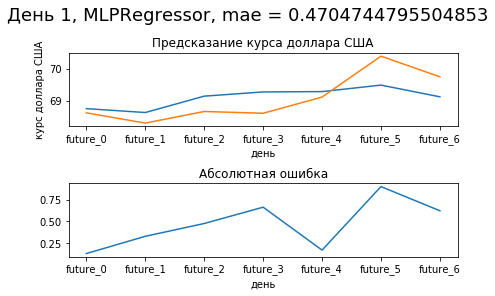

0.4704744795504853

In [238]:
check_model(mlp, "MLPRegressor", day=1)

In [239]:
check_model_days(mlp)

5

In [161]:
# При выборе трёх моделей было сделано предположение, что невыгодно выбирать модель
# линейной регресии, поскольку график нелинеен. 
# 
# Первой была выбрана модель на основе деревьев решений, поскольку это понятие
# знакомо, хоть и не понятно
#
# Второй ради эксперимента была взята модель на основе Гауссова распределения, которая
# исходя из логики и курса математики, совершенно не подходит для данной задачи
#
# После экспериментов с различными моделями стало ясно, что начальное предположение о
# невыгодности линейных моделей было не совсем верно. Третьей моделью была взята
# линейная ElasticNetCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNetCV

In [151]:
# 1. Модель на основе деревьев решений
# Среди DecisionTreeRegressor и ExtraTreeRegressor лучше себя показал первый вариант
# Для данной модели точность 0.8 достигается на 6 из 10 тестовых наборах

dtr = DecisionTreeRegressor(max_depth=100, random_state=42)
dtr.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=100,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

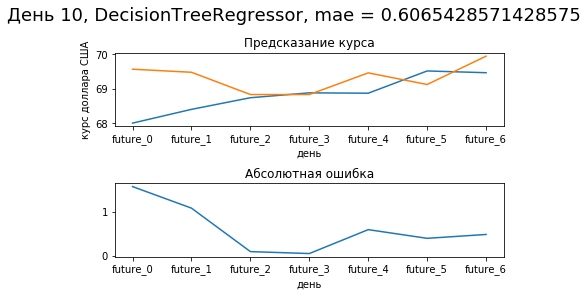

0.6065428571428575

In [156]:
check_model(dtr, "DecisionTreeRegressor", day=10)

In [148]:
check_model_days(dtr)

6

In [162]:
# 2. Модель GaussianProcessRegressor, 
# Как и ожидалось, показывает совершенно неудовлетворительный результат
# Для данной модели точность 0.8 достигается на 0 из 10 тестовых наборах

gpr = GaussianProcessRegressor(random_state=42)
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=42)

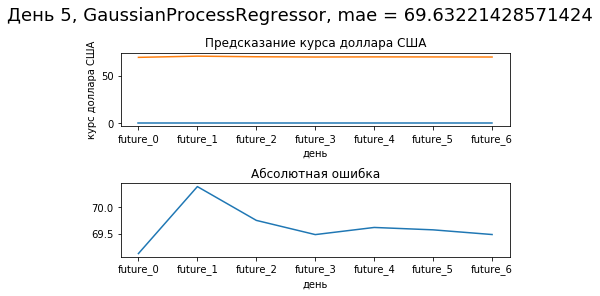

69.63221428571424

In [166]:
check_model(gpr, "GaussianProcessRegressor", day=5)

In [167]:
check_model_days(gpr)

0

In [228]:
# 3. Модель ElasticNet 
# Была выбрана для показания того, что линейная регрессия может показывать достойные результаты
# Для данной модели точность 0.8 достигается на 4 из 10 тестовых наборах

en = ElasticNet(max_iter=10000, selection='random', l1_ratio=0.55, random_state=42)
en.fit(X_train, Y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.55,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='random', tol=0.0001, warm_start=False)

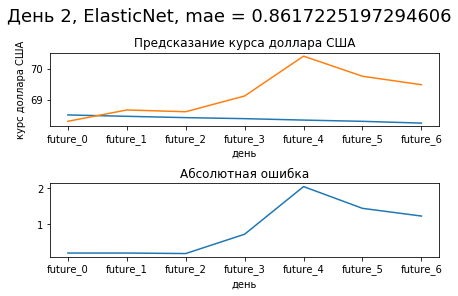

0.8617225197294606

In [229]:
check_model(en, "ElasticNet", day=2)

In [230]:
check_model_days(ard)

4

In [231]:
# Выполенение домашнего задания показало, что необходимо разбираться во внутреннем
# устройстве моделей для того, чтобы подбирать специализированную модель для определённой задачи
# Спасибо за три дня интенсива! Было очень интересно!